https://towardsdatascience.com/3-ways-to-create-a-machine-learning-model-with-keras-and-tensorflow-2-0-de09323af4d3

In [6]:
# Import standard libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd

# Keras documentation can be found on keras.io:
import tensorflow.keras
from tensorflow.keras.datasets import mnist      # NOTE: This loads the data!
# manual link to data:  http://yann.lecun.com/exdb/mnist/
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, concatenate
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import glob
from PIL import Image

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [7]:

#data = np.load('data_codingset_ash.npz',allow_pickle = True)
data = np.load('data_codingset_pollen.npz',allow_pickle = True)



#print(data['label'])

metadata_ash = np.array(data['metadata_pollen'])
data_ash = np.array(data['data_pollen'])
label = np.array(data['label'])[0]


#data_pollen = np.array( data2['data_pollen'][:100] )


print(data_ash.shape)
print(metadata_ash.shape)

#print(data_pollen.shape)



(21000, 64, 64)
(21000, 39)


In [8]:
train_images, rest_images, train_label, rest_label = train_test_split(data_ash, label, test_size=0.4, random_state=13052020)
val_images, test_images, val_labels, test_labels = train_test_split(rest_images, rest_label, test_size=0.3, random_state=13052020)


meta_train_images, meta_rest_images, meta_train_label, meta_rest_label = train_test_split(metadata_ash, label, test_size=0.4, random_state=13052020)
meta_val_images, meta_test_images, meta_val_labels, meta_test_labels = train_test_split(meta_rest_images, meta_rest_label, test_size=0.3, random_state=13052020)



# explicitly illustrating standardization
def standardizeimg(img, mu, sigma):
    return (img-mu)/(sigma).astype(np.float32)



# save for scaling test data
mu_train = np.mean(train_images)
sigma_train = np.std(train_images)

meta_mu = np.mean(meta_train_images)
meta_sigma = np.std(meta_train_images)

# Standardize pixel distribution to have zero mean and unit variance
train_images = standardizeimg(img=train_images, mu=mu_train, sigma=sigma_train)
val_images = standardizeimg(img=val_images, mu=np.mean(val_images), sigma=np.std(val_images))

meta_train_images = standardizeimg(img=meta_train_images, mu=meta_mu, sigma=meta_sigma)
meta_val_images = standardizeimg(img=meta_val_images, mu=np.mean(meta_val_images), sigma=np.std(meta_val_images))

# adapt to format required by tensorflow; Using channels_last --> (n_samples, img_rows, img_cols, n_channels)
img_rows, img_cols = 64, 64 # input image dimensions
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
val_images = val_images.reshape(val_images.shape[0], img_rows, img_cols, 1)

# convert class vectors to binary class matrices - one hot encoding
num_classes = 3
train_labels = tensorflow.keras.utils.to_categorical(train_label, num_classes)
val_labels = tensorflow.keras.utils.to_categorical(val_labels, num_classes)

# avoid using statistics intrinsic to test data to ensure unbiased estimate of real model performance
test_images = standardizeimg(img=test_images, mu=mu_train, sigma=sigma_train)
meta_test_images = standardizeimg(meta_test_images,mu = meta_mu , sigma = meta_sigma)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
test_labels = tensorflow.keras.utils.to_categorical(test_labels, num_classes)

#data_pollen = standardizeimg(img=data_pollen, mu=mu_train, sigma=sigma_train)
#data_pollen = data_pollen.reshape(data_pollen.shape[0], img_rows, img_cols, 1)


In [9]:
meta_test_images.shape

(2520, 39)

In [10]:
print(sigma_train)

38.87750251025846


In [11]:
print("Training set:")
print(" > images:", train_images.shape)
print(" > labels:", train_labels.shape)
print("Validation set:")
print(" > images:", val_images.shape)
print(" > labels:", val_labels.shape)
print("Test set:")
print(" > images:", test_images.shape)
print(" > labels:", test_labels.shape)

Training set:
 > images: (12600, 64, 64, 1)
 > labels: (12600, 3)
Validation set:
 > images: (5880, 64, 64, 1)
 > labels: (5880, 3)
Test set:
 > images: (2520, 64, 64, 1)
 > labels: (2520, 3)


# Verify first 5 mages in each split dataset

fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(10,6))

N = 64

for i in range(5):

    # train
    ax[0,i].imshow(train_images[i].reshape(N,N), cmap=plt.cm.binary)
    ax[0,i].set_xlabel(np.argmax(train_labels[i]), fontsize=18)
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([]); ax[0,i].grid(False)
    # val
    ax[1,i].imshow(val_images[i].reshape(N,N), cmap=plt.cm.binary)
    ax[1,i].set_xlabel(np.argmax(val_labels[i]), fontsize=18)
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([]); ax[1,i].grid(False)
    # test
    ax[2,i].imshow(test_images[i].reshape(N,N), cmap=plt.cm.binary)
    ax[2,i].set_xlabel(np.argmax(test_labels[i]), fontsize=18)
    ax[2,i].set_xticks([]); ax[2,i].set_yticks([]); ax[2,i].grid(False)
    
plt.tight_layout()
plt.show()

# Check for (un)balanced data

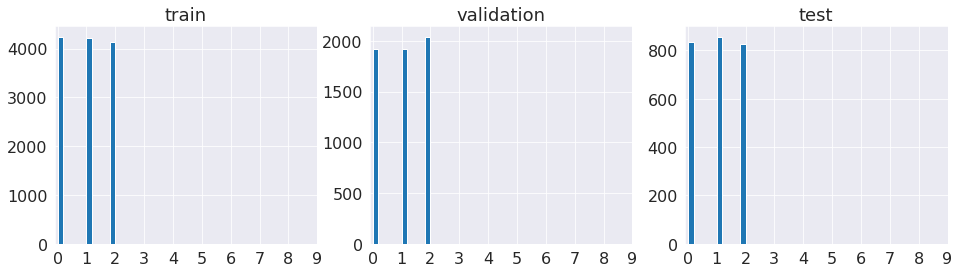

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
ax[0].hist(np.argmax(train_labels, axis=1).flatten()); ax[0].set_title('train', fontsize=18); ax[0].set_xticks(np.arange(10)); ax[0].tick_params(axis='both', which='major', labelsize=16);
ax[1].hist(np.argmax(val_labels, axis=1).flatten()); ax[1].set_title('validation', fontsize=18); ax[1].set_xticks(np.arange(10)); ax[1].tick_params(axis='both', which='major', labelsize=16);
ax[2].hist(np.argmax(test_labels, axis=1).flatten()); ax[2].set_title('test', fontsize=18); ax[2].set_xticks(np.arange(10)); ax[2].tick_params(axis='both', which='major', labelsize=16);
plt.show()

# Create architecture

In [14]:
input_img = Input(shape = (img_rows, img_cols, 1))
input_meta = Input(shape = (39,))

x = Conv2D(filters=32,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu')(input_img)
x = MaxPooling2D(pool_size=2, strides=None)(x)
x = Conv2D(filters=64,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu')(x)
x = MaxPooling2D(pool_size=2, strides=None)(x)

#Nyt start =========================================   Uden metadata var 0.68: 0.75 -> 0.77 -> 0.75 -> 0.73 -> 0.72 -> 0.75 -> 0.75
#x = Conv2D(filters=64,
#                 kernel_size=3,
#                 strides=1,
#                 padding='same',
#                 activation='relu')(x)
#x = MaxPooling2D(pool_size=2, strides=None)(x)
#x = Conv2D(filters=64,
#                 kernel_size=3,
#                 strides=1,
#                 padding='same',
#                 activation='relu')(x)
#x = MaxPooling2D(pool_size=2, strides=None)(x)
#Nyt slut ========================================== 

x = Dropout(rate=0.40)(x)

x = Flatten()(x)
x = Dense(units=128, activation='relu')(x) 
x1 = Dense(128,activation = 'sigmoid')(input_meta) #New
x = concatenate([x,x1])
x = Dense(1024,activation = 'sigmoid')(x)

output = Dense(units=num_classes, activation='softmax')(x)

model = Model(inputs = [input_img ,input_meta],outputs = output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   18496       max_pooling2d[0][0]              
______________________________________________________________________________________________

# Compile and train model

In [15]:
# specify optimization strategy and metric used for monitoring during training
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['categorical_accuracy'])

# the history object will contain a record of loss and metric values during training
history = model.fit([train_images,meta_train_images], train_labels,
                    batch_size=64,
                    epochs=7,
                    verbose=1,
                    validation_data=([val_images,meta_val_images], val_labels))

Epoch 1/7
197/197 [==============================] - 18s 88ms/step - loss: 0.6943 - categorical_accuracy: 0.6742 - val_loss: 0.3915 - val_categorical_accuracy: 0.8184
Epoch 2/7
197/197 [==============================] - 17s 84ms/step - loss: 0.3878 - categorical_accuracy: 0.8227 - val_loss: 0.3725 - val_categorical_accuracy: 0.8238
Epoch 3/7
197/197 [==============================] - 17s 87ms/step - loss: 0.3367 - categorical_accuracy: 0.8440 - val_loss: 0.3483 - val_categorical_accuracy: 0.8396
Epoch 4/7
197/197 [==============================] - 19s 97ms/step - loss: 0.3143 - categorical_accuracy: 0.8584 - val_loss: 0.3276 - val_categorical_accuracy: 0.8503
Epoch 5/7
197/197 [==============================] - 18s 89ms/step - loss: 0.2954 - categorical_accuracy: 0.8684 - val_loss: 0.3094 - val_categorical_accuracy: 0.8573
Epoch 6/7
197/197 [==============================] - 21s 108ms/step - loss: 0.2720 - categorical_accuracy: 0.8753 - val_loss: 0.3168 - val_categorical_accuracy: 0.86

In [16]:
model.save('model_pollen')

In [17]:
extractor = tensorflow.keras.Model(inputs=model.inputs,
                        outputs=model.layers[-2].output)

features_ash = extractor([train_images,meta_train_images])


# Evaluate training process

184/184 - 1s - loss: 0.3202 - categorical_accuracy: 0.8573


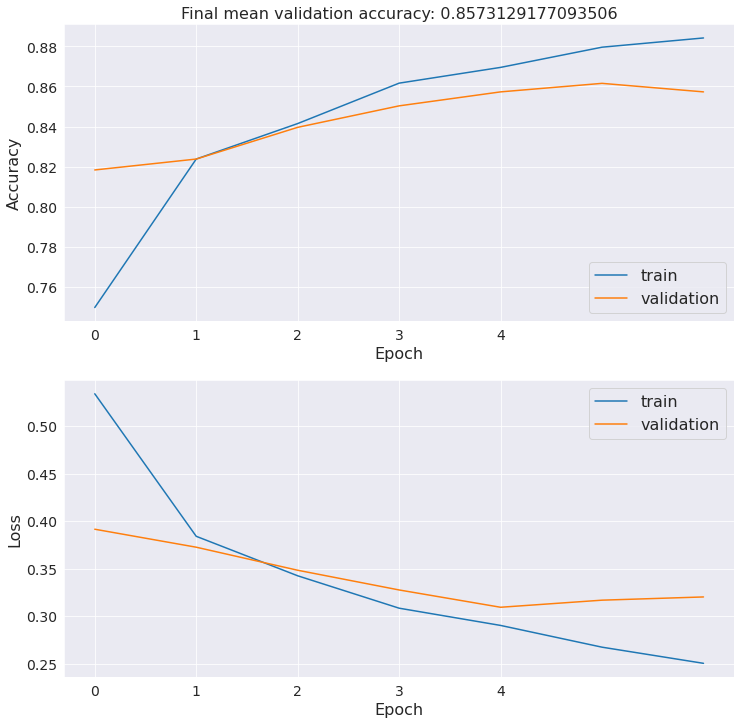

In [25]:
# evaluating model using all data (not in batches)
val_loss, val_acc = model.evaluate([val_images,meta_val_images], val_labels, verbose=2)

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(12,12))
fs_L, fs_M, fs_S = 18, 16, 14
ax[0].plot(history.history['categorical_accuracy'], label='train')
ax[0].plot(history.history['val_categorical_accuracy'], label='validation')
ax[0].set_xlabel('Epoch', fontsize=fs_M)
ax[0].set_ylabel('Accuracy', fontsize=fs_M)
ax[0].tick_params(axis='both', which='major', labelsize=fs_S)
ax[0].set_title('Final mean validation accuracy: {}'.format(val_acc), fontsize=fs_M)
ax[0].set_xticks(range(0,5))
ax[0].legend(loc='lower right', fontsize=fs_M)

ax[1].plot(history.history['loss'], label='train')
ax[1].plot(history.history['val_loss'], label='validation')
ax[1].set_xlabel('Epoch', fontsize=fs_M)
ax[1].set_ylabel('Loss', fontsize=fs_M)
ax[1].tick_params(axis='both', which='major', labelsize=fs_S)
ax[1].set_xticks(range(0,5))
ax[1].legend(loc='upper right', fontsize=fs_M)

plt.show()

# Inference

In [26]:
# using until now unseen data
predicted_prob = model.predict([test_images,meta_test_images])
predictions = np.argmax(predicted_prob, axis=1)

In [27]:
conf_matrix = tf.math.confusion_matrix(labels=np.argmax(test_labels, axis=1), predictions=predictions, num_classes=num_classes)
print('Confusion Matrix: ', conf_matrix)

# Original code:
#sess = tf.compat.v1.InteractiveSession()
#conf_matrix = confusion.eval(session=sess)     # Needs update to new TF...
#sess.close()

# Accuracy score for inference
error_rate = (np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))) / np.sum(np.diag(conf_matrix))
inf_acc = 1-error_rate

Confusion Matrix:  tf.Tensor(
[[823   9   4]
 [  5 642 210]
 [  2 117 708]], shape=(3, 3), dtype=int32)


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  fontw

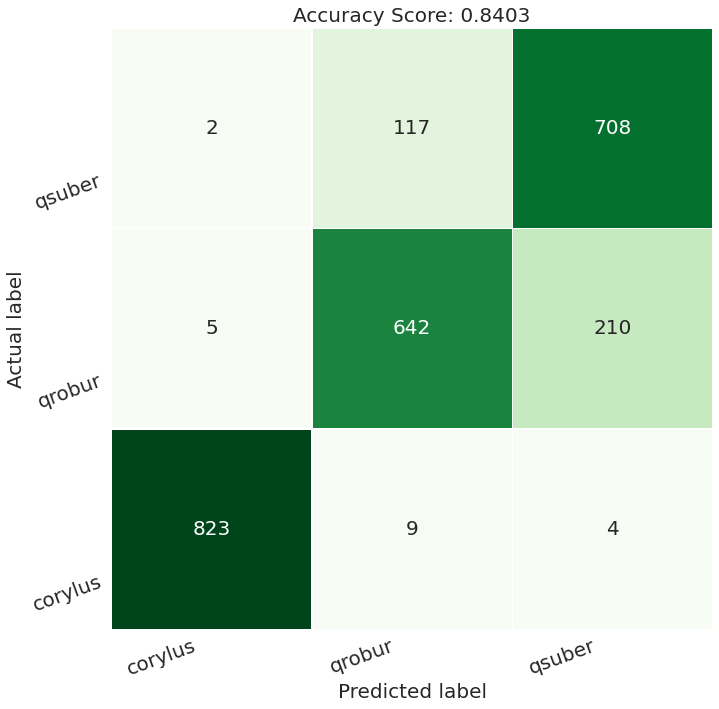

Correct: 2173/2520
Wrong: 347/2520
Correct: 2173/2520
Wrong: 347/2520


In [40]:
fig=plt.figure(figsize=(10,10))
ax = sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 20}, fmt="d", linewidths=.5, square=True, cbar=False, cmap='Greens')
ax.invert_yaxis()
plt.ylabel('Actual label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.xticks(fontsize=20); plt.yticks(fontsize=20)
plt.title('Accuracy Score: {:.4f}'.format(inf_acc), fontsize=20)

path = ["corylus","qrobur","qsuber"]

plt.xticks(range(len(path)),path, rotation=20)
plt.yticks(range(len(path)),path, rotation=20)
plt.setp( ax.xaxis.get_majorticklabels()) 

import matplotlib.transforms

# Create offset transform by 5 points in x direction
dx = 50/72.; dy = 0/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

# apply offset transform to all x ticklabels.
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

plt.setp( ax.yaxis.get_majorticklabels()) 

# Create offset transform by 5 points in x direction
dx = 0/72.; dy = 50/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

# apply offset transform to all x ticklabels.
for label in ax.yaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
plt.tight_layout()
plt.show()

print('Correct: {0}/{1}'.format(np.sum(np.diag(conf_matrix)),np.sum(conf_matrix)))
print('Wrong: {0}/{1}'.format((np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))),np.sum(conf_matrix)))
fig.savefig('pollen_conf_matrix', dpi=750)

print('Correct: {0}/{1}'.format(np.sum(np.diag(conf_matrix)),np.sum(conf_matrix)))
print('Wrong: {0}/{1}'.format((np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))),np.sum(conf_matrix)))

# Inspection of predictions

### Correctly predicted images

# show first 10 images that were correctly predicted
correct_idx = np.where(predictions == np.argmax(test_labels, axis=1))[0]

fig, axs = plt.subplots(4,5, figsize=(15, 16))
axs = axs.ravel()
for i in range(20):
    axs[i].imshow(test_images[correct_idx[i],:,:,0], cmap=plt.cm.binary)
    axs[i].set_title('predicted: {} \n actual: {}'.format(predictions[correct_idx[i]], np.argmax(test_labels, axis=1)[correct_idx[i]]), fontsize=18)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

### Wrongly predicted images

# Show first 10 images that were wrongly predicted:
wrong_idx = np.where(predictions != np.argmax(test_labels, axis=1))[0]

fig, axs = plt.subplots(4,5, figsize=(15, 16))
axs = axs.ravel()
for i in range(20):
    axs[i].imshow(test_images[wrong_idx[i],:,:,0], cmap=plt.cm.binary)
    axs[i].set_title('predicted: {} \n actual: {}'.format(predictions[wrong_idx[i]], np.argmax(test_labels, axis=1)[wrong_idx[i]]), fontsize=18)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)